In [19]:
from cslib import fetch_data, convert_to_ts, engineer_features
import time
import os
import seaborn as sns

# Model building and selection

Tasks:
* State the different modeling approaches that you will compare to address the business opportunity.
* Iterate on your suite of possible models by modifying data transformations, pipeline architectures, hyperparameters and other relevant factors.
* Re-train your model on all of the data using the selected approach and prepare it for deployment.
* Articulate your findings in a summary report.

**Model should predict the next 30 days for any given point in time. For supervised learning, the total revenue over the next thirty days can be represented as a single number.**

In [3]:
# Setup the initial variables
run_start = time.time() 
data_dir = os.path.join("..","cs-train")
print("...fetching data")

# Fetching data may take a few seconds
df = fetch_data(data_dir)

# Calculate time taken and display
m, s = divmod(time.time()-run_start,60)
h, m = divmod(m, 60)
print("load time:", "%d:%02d:%02d"%(h, m, s))

# Print the data
df.head()

...fetching data
load time: 0:00:08


,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,17998.0,28,489562,11,5.95,84656,1,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28


## Models to investigate

I will investigate the facebook prophet package as well as the ARIMA models to compare.

## Pipeline

Initially we need to obtain the data in a form that we can use in a model.

In [26]:
# Convert the dataframe to a timeseries
ts = convert_to_ts(df[df.country=='France'])
ts

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
0,2017-11-01,0,0,0,0,2017-11,0.00
1,2017-11-02,0,0,0,0,2017-11,0.00
2,2017-11-03,0,0,0,0,2017-11,0.00
3,2017-11-04,0,0,0,0,2017-11,0.00
4,2017-11-05,0,0,0,0,2017-11,0.00
...,...,...,...,...,...,...,...
602,2019-06-26,0,0,0,0,2019-06,0.00
603,2019-06-27,1,1,1,4,2019-06,1.25
604,2019-06-28,26,2,25,252,2019-06,79.75
605,2019-06-29,0,0,0,0,2019-06,0.00


In [31]:
# Create new features for training
(X, y, dates) = engineer_features(ts)

In [30]:
# The feature data
X.head()

,previous_7,previous_14,previous_28,previous_70,previous_year,recent_invoices,recent_views
0,134.25,134.25,134.25,134.25,0.0,0.107143,12.250000
1,254.27,254.27,254.27,254.27,0.0,0.172414,20.103448
2,352.42,352.42,352.42,352.42,0.0,0.233333,23.466667
3,537.15,537.15,537.15,537.15,0.0,0.300000,29.600000
4,537.15,537.15,537.15,537.15,0.0,0.300000,29.600000


In [32]:
# The response data
y[0:5]

array([1066.09,  946.07,  847.92,  663.19,  663.19])

In [33]:
# The dates
dates[0:5]

array(['2017-11-29', '2017-11-30', '2017-12-01', '2017-12-02',
       '2017-12-03'], dtype='datetime64[D]')

<AxesSubplot:xlabel='date', ylabel='revenue'>

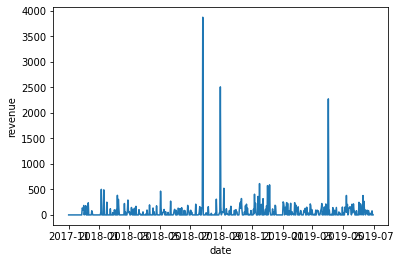

In [16]:
sns.lineplot(data=ts, x='date', y='revenue')